# NFT Price Analysis/Linear Regression

In [ ]:
%%shell
jupyter nbconvert --to html /content/NFTRegression.ipynb

[NbConvertApp] Converting notebook /content/NFTRegression.ipynb to html
[NbConvertApp] Writing 554691 bytes to /content/NFTRegression.html


### Imports


Imports, nearly all are used. Some may be leftovers from my attempts to further manipulate the data.

In [ ]:
import requests
import pandas as pd
from pandas import DataFrame
from pandas import json_normalize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns; sns.set
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin


### Gathering Data 


In the code below, you are prompted for a collection of NFTs that you would like to search. You can enter a collection such as 'sandbox' or you can leave it blank to search all collections. However, in my experience, I have seen that specifying a collection allows the data to be more comparable. 

I would've allowed you to change the 'order_by' parameter, but most of the keywords do not work for all listing.

There is a limit of 50 when retrieving assets from the OpenSea API, so I encased the url link in a for loop and formatted an offseting variable inside the url string.

In [ ]:

collection = input('Please enter the collection you would like to search: ')

params = {
    'collection': collection,
    'order_by': 'sale_count'
}
headers = {"X-API-KEY": "70f63f67185541c394da1f46fe64d1b0"}

x = 0
df = pd.DataFrame()
y = ''
for i in range(10):
  x = i*50
  y = "https://api.opensea.io/api/v1/assets?order_direction=desc&offset={}&limit=50".format(x)
  url = requests.get(y, params=params, headers=headers)
  df4 = pd.DataFrame(url.json()['assets'])
  df = pd.concat([df, df4], axis=0)
  print(i)
  #string to ensure loop is executing

#df = pd.DataFrame.reset_index(df)
#add new index row to correct numbering

Please enter the collection you would like to search: sandbox
0
1
2
3
4
5
6
7
8
9


In [ ]:
df.isnull().sum().sort_values(ascending=False)[:28]
#checking for null values so they can be removed

transfer_fee                  500
background_color              500
animation_url                 500
transfer_fee_payment_token    500
decimals                      500
animation_original_url        500
sell_orders                   500
top_bid                       500
listing_date                  500
description                   500
last_sale                       1
num_sales                       0
image_url                       0
image_preview_url               0
image_thumbnail_url             0
image_original_url              0
token_id                        0
asset_contract                  0
name                            0
external_link                   0
permalink                       0
collection                      0
token_metadata                  0
owner                           0
creator                         0
traits                          0
is_presale                      0
id                              0
dtype: int64

In [ ]:
df = df.dropna(subset=['last_sale'])
df = df.dropna(subset=['name'])
#removing null values for columns we are working with

df = pd.DataFrame.reset_index(df)
#added reset index row to correct numbering

### Unnesting Method

Since all of the data that I retrieved from OpenSea was in nested json files, I had to find a way to retrieve data that was hidden inside columns. 

So, I had to use an unnesting function to take data out of specific columns.

In [ ]:
def unnesting(df, explode, axis = 0):
    if axis==1:
        idx = df.index.repeat(df[explode[0]].str.len())
        df1 = pd.concat([
            pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
        df1.index = idx

        return df1.join(df.drop(explode, 1), how='left')
    else :
        df1 = pd.concat([
                         pd.DataFrame(df[x].tolist(), index=df.index).add_prefix(x) for x in explode], axis=1)
        return df1.join(df.drop(explode, 1), how='left')

Since the last sale price was nested inside the 'last_sale' column, I had to unnest this data so that I could concatenate this column to the trimmed down dataframe.

However, the last sale price is standardized for each transaction. This means that I had to run transformations on the last sale price in order to get the true price. 

I ran into another hiccup here because all the information on the transformations was nested further inside the 'last_sale' column. In order to remedy this, I had to unnest a column inside my unnested df. This could probably be done with some type of recursive function, but I could not figure one out.

In [ ]:
dfcopy = unnesting(df,['last_sale'], axis=0).copy()
convert = unnesting(dfcopy, ['last_salepayment_token']).copy()

### DataFrame Organization and Corrections

Here, I used a the pandas concatenate method to combine the columns that I was interested in. I also had to change the datatype on two columns so that operations could be run on them.

I used a lambda function to convert the tokens to USD. This function is able to convert all the different tokens to their USD value with fairly high accuracy. The only limit is that the 'token to usd' price is handled by OpenSea which makes the numbers slightly off of their real life value.

In [ ]:
dftrim = pd.concat([df['name'], df['id'],df['image_url'] ,df['num_sales'],
                 convert['last_salepayment_tokenname'],dfcopy['last_saletotal_price'],
                 convert['last_salepayment_tokenusd_price'],convert['last_saleevent_timestamp']], axis=1, 
                keys=['name','id','image url','# of sales','purchase token used','amount of token','token to usd', 'sale date'])

dftrim['amount of token'] = dftrim['amount of token'].astype(str).astype(float)
dftrim['amount of token'] = dftrim['amount of token'].apply(lambda x: x/10**18)
dftrim['token to usd'] = dftrim['token to usd'].astype(str).astype(float)
dftrim['sale date'] = pd.to_datetime(dftrim['sale date'])
dftrim['usd price'] = dftrim.apply(lambda x: x['amount of token'] * x['token to usd'], axis=1)
dftrim

name      id  ...           sale date     usd price
0    CryptoPunk #3914  178723  ... 2021-08-07 00:51:31  4.192660e+05
1    CryptoPunk #5575  528401  ... 2021-09-17 18:32:57  4.598929e+05
2    CryptoPunk #8970  530505  ... 2021-08-28 05:11:07  3.918879e+05
3    CryptoPunk #7392  179340  ... 2021-10-12 21:58:59  4.179663e+05
4    CryptoPunk #6989  177426  ... 2021-08-19 01:50:30  2.096330e+05
..                ...     ...  ...                 ...           ...
494  CryptoPunk #9152  179739  ... 2021-05-02 09:36:04  1.005819e+05
495  CryptoPunk #6649  177054  ... 2021-07-31 14:11:48  3.396055e+06
496  CryptoPunk #7812  176694  ... 2021-08-03 16:04:45  1.651908e+05
497  CryptoPunk #1417  176691  ... 2021-09-30 19:49:13  4.732675e+05
498  CryptoPunk #3441  527087  ... 2021-07-12 15:02:13  3.354128e+05

[499 rows x 9 columns]

### Plotting Code

I ran this each time with a different collection specified. The only things that needed to change were the x and y axis ranges.

Text(0, 0.5, 'Sale price (USD)')

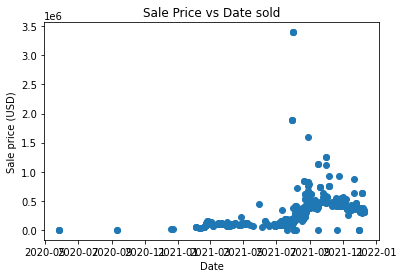

In [ ]:
dates = matplotlib.dates.date2num(dftrim['sale date'])
plt.plot_date(dates, dftrim['usd price'])
plt.title("Sale Price vs Date sold")
plt.xlabel("Date")
plt.ylabel("Sale price (USD)")

It was difficult to run operations on a DateTime value, but I was able to convert the date information into numerical data so that it can be evaluated.


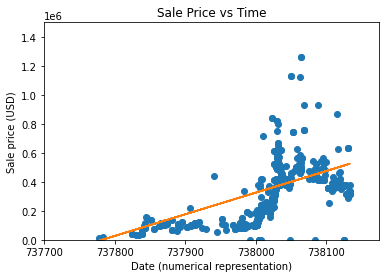

In [ ]:
plt.scatter(dates, dftrim['usd price'])
poly_model.fit(dates[:, np.newaxis], dftrim['usd price'])

yfit = poly_model.predict(xfit[:, np.newaxis])

plt.plot(xfit, yfit);
plt.ylim([0, 1500000])
plt.xlim([737700,738175])

m, b = np.polyfit(dates, dftrim['usd price'], 1)
plt.title("Sale Price vs Time")
plt.xlabel("Date (numerical representation)")
plt.ylabel("Sale price (USD)")
plt.plot(dates, m*dates+b)


Text(0, 0.5, 'Sale price (USD)')

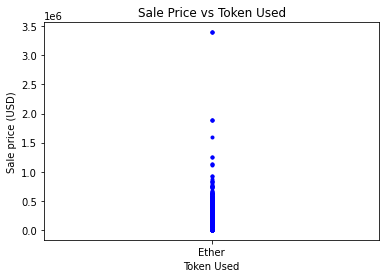

In [ ]:
plt.plot(dftrim['purchase token used'],dftrim['usd price'], 'b.')
plt.title("Sale Price vs Token Used")
plt.xlabel("Token Used")
plt.ylabel("Sale price (USD)")

In [ ]:
plt.plot(dftrim['# of sales'],dftrim['usd price'], 'b.')
plt.title("# of sales vs Sale Price (USD)")
plt.xlabel("# of Sales")
plt.ylabel("Sale price (USD)")

m, b = np.polyfit(dftrim['# of sales'], dftrim['usd price'], 1)


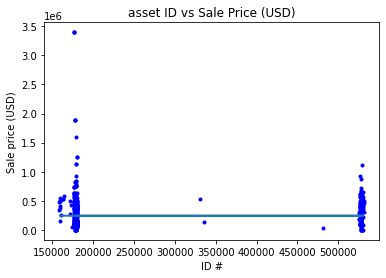

In [ ]:
plt.plot(dftrim['id'],dftrim['usd price'], 'b.')
plt.title("asset ID vs Sale Price (USD)")
plt.xlabel("ID #")
plt.ylabel("Sale price (USD)")

m, b = np.polyfit(dftrim['id'], dftrim['usd price'], 1)
plt.plot(dftrim['id'], m*dates+b)

# Analysis

I wanted to run more advanced regressions on this data, but the data is not condusive for such analysis. There are many outliers that seem to disagree with many of the regressions we have gone over.

However, I did notice that you could get much better results from running this analysis on NFTs from a single collection. I believe this is because collections have themes and popularity. These factors (among many others) allow the data to be more interpretable. 

There were also times where I had to manually edit the ranges for the x and y axis. I believe this is because I am using so much data that there are huge outliers in nearly every column.

1.png 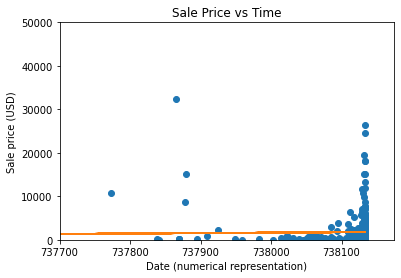

This graph is for all collections, sorted by most sales. It shows the USD value for the last sale of the NFT compared to the date that the last sale occured.

I ran into an issue here where DateTime cannot be evaluated since it is not a traditional datatype. This can be overcome by converting the DateTime values to numerical time values that can be understood more easily. 

This graph shows the previous graph with a best-fit line going through it. 

Since all of this data is pulled from different collections, it is hard to find correlation between price. Even so, this graph still shows an slight positive trend in price over time.

I was not able to use other regressions with DateTime, I imagine this could be overcome by creating a method to alter the sale date column.

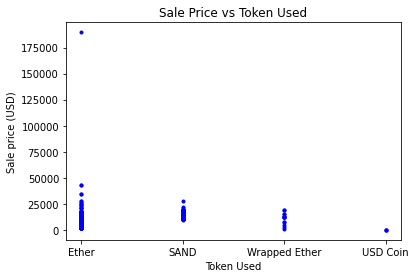

This graph compares the USD price to the token used for purchase. I wasnt not able to create a best fit line because strings cannot be compared here. I could give each token a number, but this feels redundant since there are so many different tokens. 

There is a trend that NFTs purchased with more valuable tokens tend to have a higher price. This makes sense since individuals may be more likely to purchase low-cost NFTs with a low-cost token.

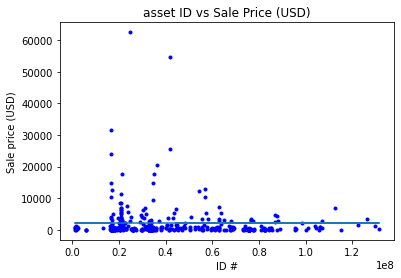

This graph is just to examine the correlation between ID and price. While there does not seem to be a large correlation, there does seem to be a higher concentration of sales with lower Asset IDs.

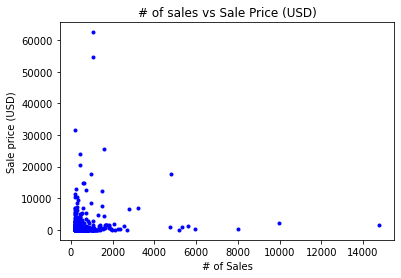

This graph shows the number of sales compared to the USD price. It is interesting that there seem to be many NFTs that have been sold >1000 times. This makese me wonder how many real purchases there have been.

## CryptoPunks Analysis

Something I noticed, which is quite peculiar, is that there are many coins that have 'sold' for many millions of dollars worth of cryptocurrency. 

*note*: After tracking down some of these NFTs, it appears that many NFTs are traded back and forth to inflate their value. 

The CryptoPunks collection is a good example of how these sales inflate the value of NFTs. These inflations can make it difficult to evaluate real price fluctuations. Here you will see an NFT from CryptoPunks that sold for nearly 4 million dollars. 

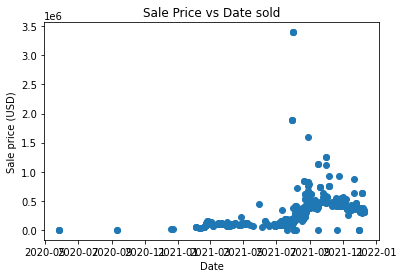
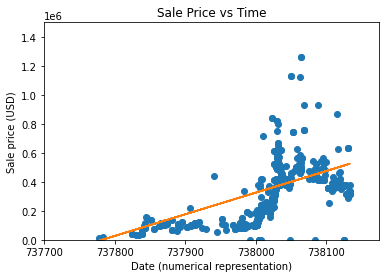

This graph really exemplifies why these inflation sales mess up the data. The scale of the y-axis is 10^6. As you can see, the **vast** majority of sales are for very small amounts of USD. 

You can also see how this data is much more manageable than the data from random collections. 

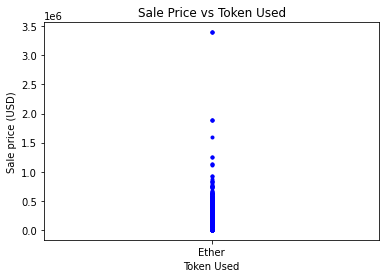

It is iteresting to me that, out of 500 transactions, all of them were done on the ETH network.

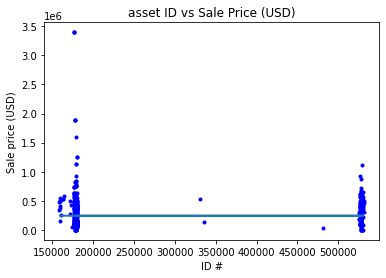

Another graph showing the Asset ID compared to the Sales price. There is no correlation, but there are very large concentrations among high and low ID numbers.

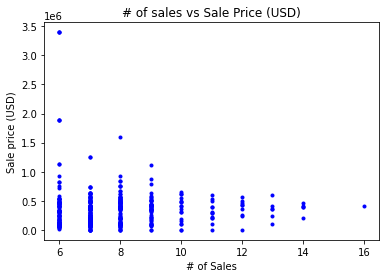 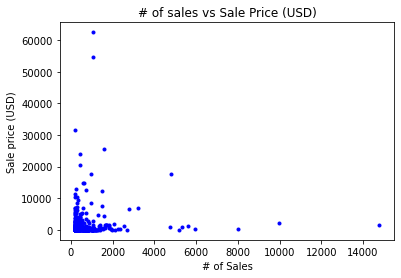

On the left is the data from CryptoPunks and the right is the data from random collections.

It is very interesting when these two graphs are juxtaposed. CryptoPunks NFTs have been traded many many less times than the random NFTs.

However, since I am sorting the assets by sale_count this probably makes my data lean towards NFT's with more transactions.